In [36]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

## The Importance of Structure In Machine Learning

It is tempting to think that machine learning algorithms do whatever they need to maximise a given reward function. Indeed, this sentiment is generally echoed in the literature - it is not a causal approach, but it can leverage all available correlations / associations.

Unfortunately, things are not quite *that* simple. 

As we aim to demonstrate below, the structure of the Data-Generating-Process (DGP) interacts strongly with the regressor we use, even if the regressor is something highly adaptive and flexible (like a random forest).

The consequences of this reality are:
- we cannot reliably identify the presence of associations between predictors an outcome
- when using explainability techniques (like decision tree importances, or Shapley values), we can only understand something about what the *model* is doing, and yet this is *strongly* yet *arbitrarily* determined by what is happening in the real-world.


### 1. Start by generating data according to some causal structure

In [52]:
N = 3000
C = np.random.randn(N,1)   # exogenous cause of X
A = 0.8 * np.random.randn(N,1)  # backdoor adjustment variable (also cause of X)
K = A + 0.1 * np.random.randn(N,1)  # backdoor adjustment variable (cause of A and Y)
X = C - 2*A + 0.2 * np.random.randn(N,1)  # treatment variable
F = 3*X + 0.8 * np.random.randn(N,1)  # descendent of treatment variable
D = -2*X + 0.5 * np.random.randn(N,1)  # mediator between x and y
G = D + 0.5 * np.random.randn(N,1)  # descendent of mediator
Y = 2*K - D + 0.2 * np.random.randn(N,1)  # outcome variable 
H = 0.5*Y + 0.1 * np.random.randn(N,1)  # effect of Y

### 2. Create a little function that provides plots of RF importances for a given set of preds and outcome

In [53]:
def plot_importances(predictors, outcome, feature_names):

    X_train, X_test, y_train, y_test = train_test_split(predictors, outcome, test_size=0.4, random_state=42)

    forest = RandomForestRegressor(random_state=0)
    forest.fit(X_train, y_train)
    predictions = forest.predict(X_test)
    importances = forest.feature_importances_
    forest_importances = pd.Series(importances, index=feature_names)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    print('MSE', mean_squared_error(predictions, y_test))

### 3. Invesigate X->Y. Start by looking at the result with ALL variables included

Let's say we are interested to know how important 'X' is for predicting 'Y'.

Look at the result. Only one variable is deemed to be important, and this is 'H'.

Actually, according to our structure defined above, 'H' is an effect of Y. Somehow, none of the other variables are deemed important, even though they are all highly correlated with Y!

Already... things are pretty weird. From these results, it seems 'X' is not associated at all.

MSE 0.0423928030681844
0.001108709569969439
C 0.009878539816157932
A -0.07186096626637917
K 1.0234231781873404
X -0.02241273866147024
F -0.0002272414855871152
D -0.4954229481636393
G 0.0027990445247643714
H 1.0259210503223988


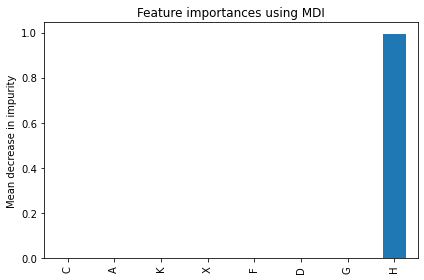

In [62]:
predictors = np.concatenate((C, A, K, X, F, D, G, H),1)
outcome =  Y[:,0]
feature_names = ['C', 'A', 'K', 'X', 'F', 'D', 'G', 'H']

plot_importances(predictors, outcome, feature_names)

# compare with linear regression coefficients
reg = LinearRegression().fit(predictors, outcome)
print(reg.intercept_)
for i, n in enumerate(feature_names):
    print(n, reg.coef_[i])

### 4. Let's remove the effect of Y, which is 'H'

Removing 'H', now 'D' is deemed to be very important.

Note that 'D' is a mediator between our treatment 'X' and our outcome 'Y'.

If we know anything about d-separation and Structural Causal Models (SCMS), we might already understand why 'X' is stil not showing up as important - our mediator 'D' is blocking the path!

MSE 0.10466951996134975
0.0014801263642593224
[ 0.0123399  -0.07572247  2.04664679 -0.01363346 -0.00237374 -0.99891181
 -0.00269145]


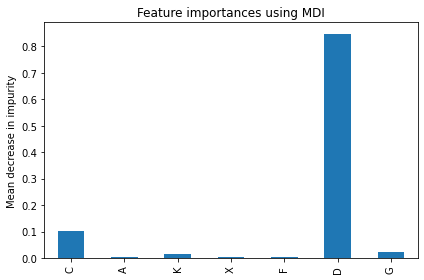

In [60]:
# remove effect of y
predictors = np.concatenate((C, A, K, X, F, D, G),1)
outcome =  Y[:,0]
feature_names = ['C', 'A', 'K', 'X', 'F', 'D', 'G']

plot_importances(predictors, outcome, feature_names)



### 5. Now let's remove the mediator 'D'. Surely *now* we will see 'X' linked with 'Y'?

Still not! The results now show that 'G' is the most important! But 'G' is an effect (i.e. a descendent) of mediator 'D'. Again, if we know the rules of d-separation, we know that adjusting/conditioning for descendents of mediators also blocks the path.

This shows just how much our model is interacting with the structure of the data!

MSE 0.2537180407124859
0.004627768276548122
[ 0.03215904 -0.13260101  2.07754012  0.96630733 -0.00380448 -0.50377184]


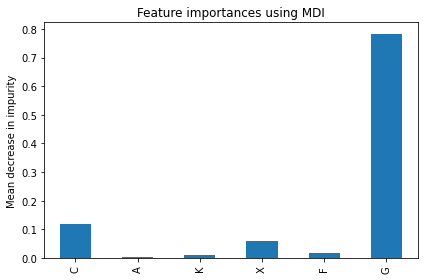

In [59]:
# remove mediator
predictors = np.concatenate((C, A, K, X, F, G),1)
outcome =  Y[:,0]
feature_names = ['C', 'A', 'K', 'X', 'F', 'G']

plot_importances(predictors, outcome, feature_names)


### 6. Let's remove the descendent of the mediator, surely now we see X linked to Y?

Indeed, finally, there is a strong association identified between 'X' and 'Y'. This is because finally we have not blocked *any* paths between 'X' and 'Y', and so all information can flow between them. Note that this includes spurious (non-causal) paths as well. And indeed, given our structure defined at the start, there is a backdoor path through 'A' and 'K' to 'Y'.

MSE 0.3758071893242951


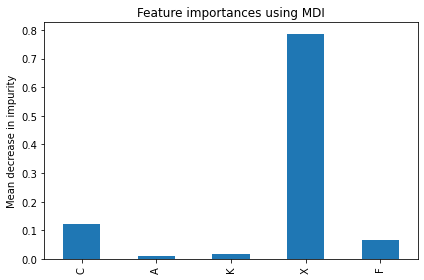

In [57]:
# remove desc of mediator
predictors = np.concatenate((C, A, K, X, F),1)
outcome =  Y[:,0]
feature_names = ['C', 'A', 'K', 'X', 'F']

plot_importances(predictors, outcome, feature_names)

MSE 0.04546861536958523
0.0019093002241832371
[ 0.01266874 -0.08944175  0.277447    0.19415543  0.00273725  1.78518955]


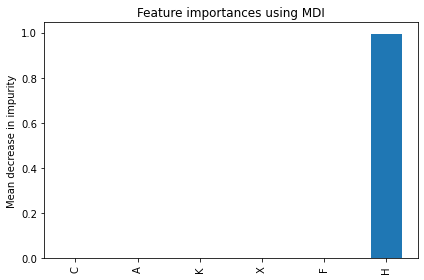

In [58]:
predictors = np.concatenate((C, A, K, X, F, H),1)
outcome =  Y[:,0]
feature_names = ['C', 'A', 'K', 'X', 'F', 'H']

plot_importances(predictors, outcome, feature_names)

# compare with linear regression coefficients
reg = LinearRegression().fit(predictors, outcome)
print(reg.intercept_)
print(reg.coef_)

MSE 0.38777728959632635
0.008300419069873825
[-0.06097449  2.01630021  1.98545151]


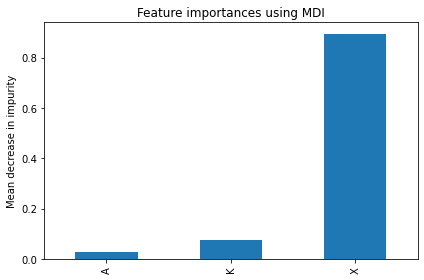

In [49]:
predictors = np.concatenate((A, K, X),1)
outcome =  Y[:,0]
feature_names = ['A', 'K', 'X']

plot_importances(predictors, outcome, feature_names)

# compare with linear regression coefficients
reg = LinearRegression().fit(predictors, outcome)
print(reg.intercept_)
print(reg.coef_)

### 7. Conclusion so far? RFs interact strongly with the structure in the data, just like any linear regression model does! 

Importances really tell us nothing reliable about the presence of associations in the data. Depending on which variables we included in the model (and the associated structure) we may get completely the wrong idea: variables which might even be *more strongly* associated than one which has high RF importance, may be represented as not being important at all...

### 8. What now?

Now we confirm that this situation holds when using state of the art model explainability techniques like Shapley values! The analyses below take a while to run, and you may need to install a few packages to use the 'RFShap' function in RF_Shap_v2.py.


## Conclusion:
As you can see below, the problems persist with Shapley.

It is hard to escape from the consequences of structural misspecification...

In [34]:
from RF_Shap_v2 import RFShap
import os
from sklearn.model_selection import KFold


k = 10
num_disp_1 = 20
class_ = 'RF'
config = None
k_cv = 'k_fold'
trn_tst_split = 0.6

od = '/home/matthewvowels/GitHub/Psych_ML/ML_structural_interactions/output/'

def make_folder(path):
        if not os.path.exists(path):
            os.makedirs(path)

impute = 0

folder = '/home/matthewvowels/GitHub/Psych_ML/Data/'
all_vars = np.concatenate((C, A, K, X, F, D, G, H, Y),1)
feature_names = ['C', 'A', 'K', 'X', 'F', 'D', 'G', 'H', 'Y']
df = pd.DataFrame(all_vars)
df.columns = feature_names

Preparing dataset...
Check if continuous or categorical variables: 
{'C': False, 'A': False, 'K': False, 'X': False, 'F': False, 'D': False, 'G': False, 'H': False, 'Y': False}
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  1
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  2
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  3
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  4
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  5
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  6
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  7
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  8
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  9
Crea

model_output = "margin" has been renamed to model_output = "raw"


Generating Shap values
(3000, 8) [7 0 5 6 2 3 4 1]


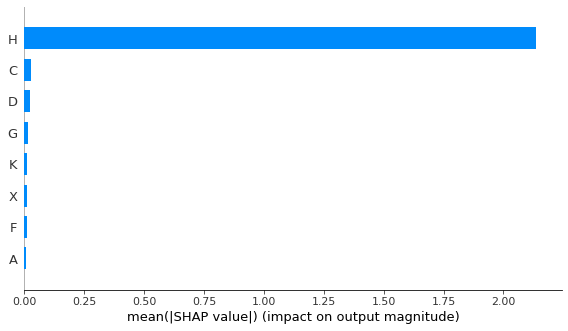

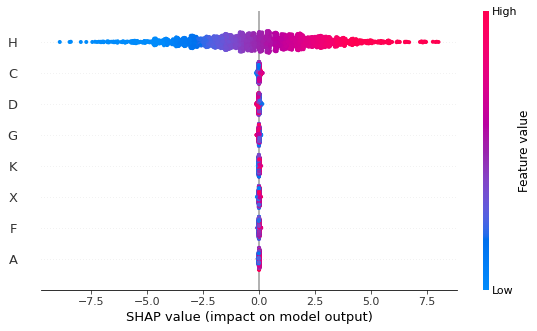

In [35]:
outcome_var = 'Y'
remove_cols = []
results_dir = os.path.join(od, outcome_var + '_all')
make_folder(results_dir)

shap_env = RFShap(model_dir=None, exclude_vars=remove_cols, outcome_var=outcome_var,
                  output_dir=results_dir, random_seed=42, class_=class_,type_='reg', balanced='balanced', trn_tst_split=trn_tst_split,
                    k_cv=k_cv, k=k)
ds, X, y, xtr, xts, ytr, ytst, _  = shap_env.munch(dataset=df)
model = shap_env.make_model(config)
model, report = shap_env.train_test()

explainer, shap_vals = shap_env.run_shap_explainer(model=model)

specific_var = None
interaction_vars = None
interaction_vals = shap_env.shap_plot(explainer=explainer, shap_vals=shap_vals, specific_var=specific_var, interactions=False, interaction_vars=interaction_vars, classwise=True, class_ind=1, num_display=num_disp_1)   

Preparing dataset...
Check if continuous or categorical variables: 
{'C': False, 'A': False, 'K': False, 'X': False, 'F': False, 'D': False, 'G': False, 'Y': False}
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  1
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  2
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  3
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  4
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  5
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  6
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  7
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  8
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  9
Creating fresh m

model_output = "margin" has been renamed to model_output = "raw"


(3000, 7) [5 0 2 6 1 4 3]


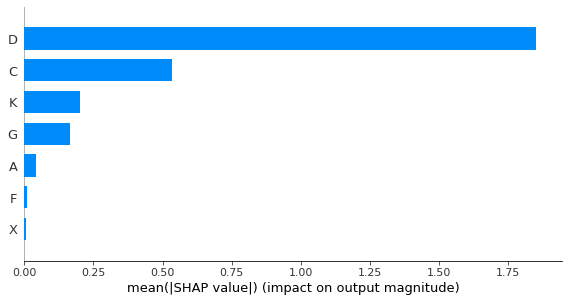

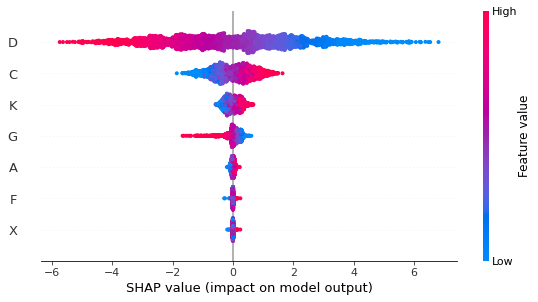

In [11]:
outcome_var = 'Y'
remove_cols = ['H']
results_dir = os.path.join(od, outcome_var + '_incl_mediator')
make_folder(results_dir)

shap_env = RFShap(model_dir=None, exclude_vars=remove_cols, outcome_var=outcome_var,
                  output_dir=results_dir, random_seed=42, class_=class_,type_='reg', balanced='balanced', trn_tst_split=trn_tst_split,
                    k_cv=k_cv, k=k)
ds, X, y, xtr, xts, ytr, ytst, _  = shap_env.munch(dataset=df)
model = shap_env.make_model(config)
model, report = shap_env.train_test()

explainer, shap_vals = shap_env.run_shap_explainer(model=model)

specific_var = None
interaction_vars = None
interaction_vals = shap_env.shap_plot(explainer=explainer, shap_vals=shap_vals, specific_var=specific_var, interactions=False, interaction_vars=interaction_vars, classwise=True, class_ind=1, num_display=num_disp_1)   

Preparing dataset...
Check if continuous or categorical variables: 
{'C': False, 'A': False, 'K': False, 'X': False, 'F': False, 'G': False, 'Y': False}
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  1
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  2
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  3
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  4
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  5
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  6
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  7
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  8
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  9
Creating fresh model...
Crea

model_output = "margin" has been renamed to model_output = "raw"


(3000, 6) [5 0 3 2 4 1]


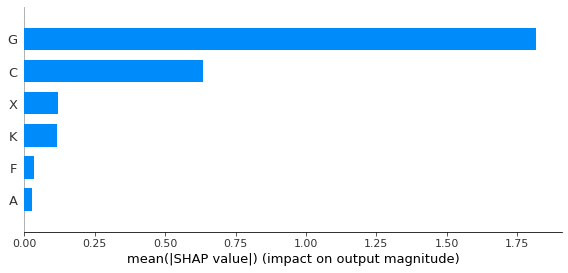

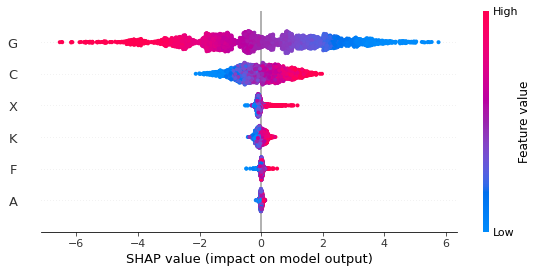

In [12]:
outcome_var = 'Y'
remove_cols = ['H', 'D']
results_dir = os.path.join(od, outcome_var + '_incl_desc_mediator')
make_folder(results_dir)

shap_env = RFShap(model_dir=None, exclude_vars=remove_cols, outcome_var=outcome_var,
                  output_dir=results_dir, random_seed=42, class_=class_,type_='reg', balanced='balanced', trn_tst_split=trn_tst_split,
                    k_cv=k_cv, k=k)
ds, X, y, xtr, xts, ytr, ytst, _  = shap_env.munch(dataset=df)
model = shap_env.make_model(config)
model, report = shap_env.train_test()

explainer, shap_vals = shap_env.run_shap_explainer(model=model)

specific_var = None
interaction_vars = None
interaction_vals = shap_env.shap_plot(explainer=explainer, shap_vals=shap_vals, specific_var=specific_var, interactions=False, interaction_vars=interaction_vars, classwise=True, class_ind=1, num_display=num_disp_1)   

Preparing dataset...
Check if continuous or categorical variables: 
{'C': False, 'A': False, 'K': False, 'X': False, 'F': False, 'Y': False}
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  1
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  2
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  3
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  4
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  5
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  6
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  7
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  8
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  9
Creating fresh model...
Created:  Random

model_output = "margin" has been renamed to model_output = "raw"


(3000, 5) [3 0 4 2 1]


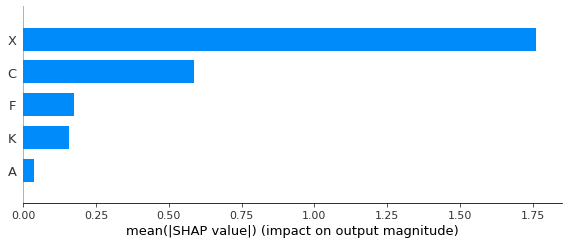

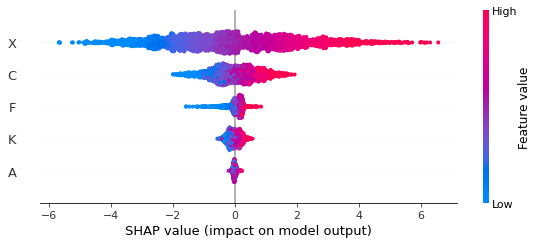

In [13]:
outcome_var = 'Y'
remove_cols = ['H', 'D', 'G']
results_dir = os.path.join(od, outcome_var + '_no_blocked_paths')
make_folder(results_dir)

shap_env = RFShap(model_dir=None, exclude_vars=remove_cols, outcome_var=outcome_var,
                  output_dir=results_dir, random_seed=42, class_=class_,type_='reg', balanced='balanced', trn_tst_split=trn_tst_split,
                    k_cv=k_cv, k=k)
ds, X, y, xtr, xts, ytr, ytst, _  = shap_env.munch(dataset=df)
model = shap_env.make_model(config)
model, report = shap_env.train_test()

explainer, shap_vals = shap_env.run_shap_explainer(model=model)

specific_var = None
interaction_vars = None
interaction_vals = shap_env.shap_plot(explainer=explainer, shap_vals=shap_vals, specific_var=specific_var, interactions=False, interaction_vars=interaction_vars, classwise=True, class_ind=1, num_display=num_disp_1)   

Preparing dataset...
Check if continuous or categorical variables: 
{'A': False, 'K': False, 'X': False, 'Y': False}
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  1
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  2
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  3
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  4
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  5
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  6
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  7
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  8
Creating fresh model...
Created:  RandomForestRegressor(random_state=42)
Training fold:  9
Creating fresh model...
Created:  RandomForestRegressor(random_s

model_output = "margin" has been renamed to model_output = "raw"


(3000, 3) [2 1 0]


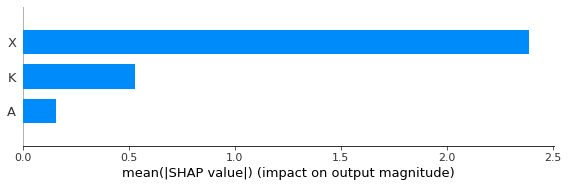

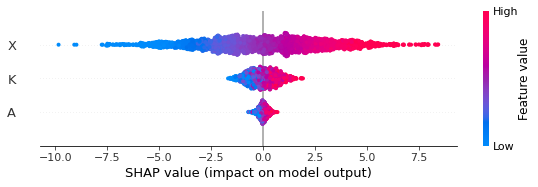

In [50]:
outcome_var = 'Y'
remove_cols = ['H', 'D', 'G', 'C', 'F']
results_dir = os.path.join(od, outcome_var + '_no_blocked_paths')
make_folder(results_dir)

shap_env = RFShap(model_dir=None, exclude_vars=remove_cols, outcome_var=outcome_var,
                  output_dir=results_dir, random_seed=42, class_=class_,type_='reg', balanced='balanced', trn_tst_split=trn_tst_split,
                    k_cv=k_cv, k=k)
ds, X, y, xtr, xts, ytr, ytst, _  = shap_env.munch(dataset=df)
model = shap_env.make_model(config)
model, report = shap_env.train_test()

explainer, shap_vals = shap_env.run_shap_explainer(model=model)

specific_var = None
interaction_vars = None
interaction_vals = shap_env.shap_plot(explainer=explainer, shap_vals=shap_vals, specific_var=specific_var, interactions=False, interaction_vars=interaction_vars, classwise=True, class_ind=1, num_display=num_disp_1)   